# Pattern classification
This tutorial is about the basics of pattern analysis of (f)MRI data.

It is based partly on the online textbook here:
https://lukas-snoek.com/NI-edu/fMRI-pattern-analysis/week_1/design_and_pattern_estimation.html

The notebook is a continuation of the `11_pattern_classification.pynb' notebook, so make sure to (re)visit that one.

Functional MRI data are most often stored as 4D data, with 3 spatial dimensions ($X$, $Y$, and $Z$) and 1 temporal dimension ($T$). But most pattern analyses assume that data are formatted in 2D: trials ($N$) by patterns (often a subset of $X$, $Y$, and $Z$). Where did the time dimension ($T$) go? And how do we "extract" the patterns of the $N$ trials? In this lab, we'll take a look at various methods to estimate patterns from fMRI time series.

Let's start by importing some packages.

<div class="alert alert-success" role="alert">

# Preamble: Activate environment
In the first notebook, we installed a python environment. If you haven't don so, please go back to the ```01_setup_virtual_environment.ipynb``` and complete this before proceeding.

If you closed/stopped the UCloud run between then and now, we will need to reactivate the environment.

For this we use a bash script with a subset of the lines we used for setting up the environment

The script called ```activate.sh``` This should be located in your working directory. If not, save the following in a file with this filename.

```bash
. /work/<MY DIRECTORY NUMBER>/virt_env/bin/activate
python -m ipykernel install --user --name=virt_env
echo Done! Remember changing the kernel in Jupyter.
```
</div>

In [1]:
import os
path='/work/798873' # Remember to change this to your own path
os.chdir(path)
!./activate.sh


Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


<div class="alert alert-success" role="alert">
    
### Check that we are in the right environment

</div>

In [96]:
import os
import pip
import sys
print(sys.executable)
#Check that we have something installed.
import nilearn
import nibabel as nib
import matplotlib.pyplot as plt

/work/798873/virt_env/bin/python


In [3]:
# We'll also install something called 'aws' which will allow us to transfer data

# The function below only works on Linux, but you can find other ways to install aws here:
#https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

# Check if it is already installed
hest=!aws --version
if hest is not [] or ['/bin/sh: 1: aws: not found']:
    print(hest)
else:
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip awscliv2.zip
    !sudo ./aws/install

['aws-cli/2.13.32 Python/3.11.6 Linux/5.4.228.el8 exe/x86_64.ubuntu.22 prompt/off']


In [4]:
# We need to limit the amount of threads numpy can use, otherwise
# it tends to hog all the CPUs available when using Nilearn
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np

## Estimating patterns
Recall that pattern classification most often relies on preparing our data as an $N$ (samples) $\times$ $K$ (features) array.

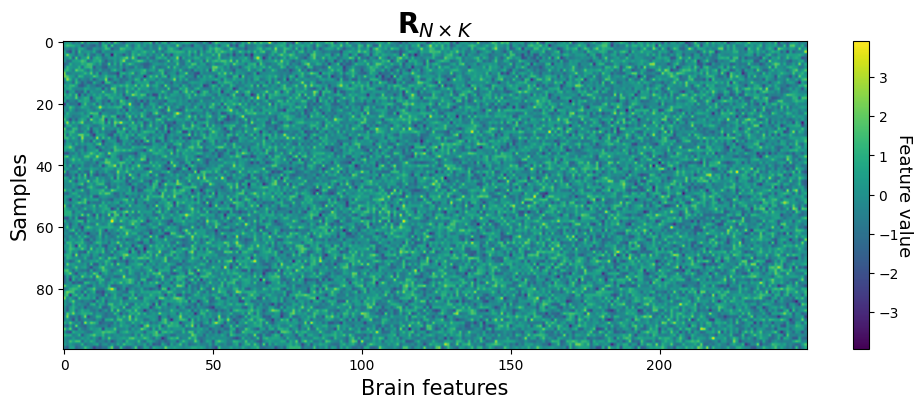

In [13]:
import numpy as np
N = 100  # e.g. trials
K = 250   # e.g. voxels

R = np.random.normal(0, 1, size=(N, K))

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 4))
plt.imshow(R, aspect='auto')
plt.xlabel('Brain features', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.title(r'$\mathbf{R}_{N\times K}$', fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=10)
plt.show()

### From 4D to 2D

With fMRI data, our data is formatted as a $X \times Y \times Z \times T$ array; we can flatten the $X$, $Y$, and $Z$ dimensions, but we still have to find a way to "extract" patterns for our $N$ trials from the time series (i.e., the $T$ dimension). 

### Important side note: single trials vs. (runwise) average trials
In this section, we often assume that our "samples" refer to different *trials*, i.e., single instances of a stimulus or response (or another experimentally-related factor). This is, however, not the only option. Sometimes, researchers choose to treat multiple repetitions of a trial as a single sample or multiple trials within a condition as a single sample. For example, suppose you design a simple passive-viewing experiment with images belonging two one of three conditions: faces, houses, and chairs. Each condition has ten exemplars (face1, face2, ..., face10, house1, house2, ..., house10, chair1, chair2, ... , chair10) and each exemplar/item is repeated six times. So, in total there are 3 (condition) $\times$ 10 (examplars) $\times$ 6 (repetitions) = 180 trials. Because you don't want to bore the participant to death, you split the 180 trials into two runs (90 each).
    
Now, there are different ways to define your samples. One is to treat every single trial as a sample (so you'll have a 180 samples). Another way is to treat each exemplar as a sample. If you do so, you'll have to "pool" the pattern estimates across all 6 repetitions (so you'll have $10 \times 3 = 30$ samples). And yet another way is to treat each condition as a sample, so you'll have to pool the pattern estimates across all 6 repetitions and 10 exemplars per condition (so you'll end up with only 3 samples). Lastly, with respect to the latter two approaches, you may choose to only average repetitions and/or exemplars *within* runs. So, for two runs, you end up with either $10 \times 3 \times 2 = 60$ samples (when averaging across repetitions only) or $3 \times 2 = 6$ samples (when averaging across examplars and repetitions).

Whether you should perform your pattern analysis on the trial, examplar, or condition level, and whether you should estimate these patterns across runs or within runs, depends on your research question and analysis technique. For example, if you want to decode exemplars from each other, you obviously should not average across exemplars. Also, some experiments may not have different exemplars per condition (or do not have categorical conditions at all). With respect to the importance of analysis technique: when applying machine learning analyses to fMRI data, people often prefer to split their trials across many (short) runs and &mdash; if using a categorical design &mdash; prefer to estimate a single pattern per run. This is because samples across runs are not temporally autocorrelated, which is an important assumption in machine learning based analyses. Lastly, for any pattern analysis, averaging across different trials will increase the signal-to-noise ratio (SNR) for any sample (because you average out noise), but will decrease the statistical power of the analysis (because you have fewer samples). 

Long story short: whatever you treat as a sample &mdash; single trials, (runwise) exemplars or (runwise) conditions &mdash; depends on your design, research question, and analysis technique. In the rest of the tutorial, we will usually refer to samples as "trials", as this scenario is easiest to simulate and visualize, but remember that this term may equally well refer to (runwise) exemplar-average or condition-average patterns.

---

To make the issue of estimating patterns from time series a little more concrete, let's simulate some signals. We'll assume that we have a very simple experiment with two conditions (A, B) with ten trials each (interleaved, i.e., ABABAB...AB), a trial duration of 1 second, spaced evenly within a single run of 200 seconds (with a TR of 2 seconds, so 100 timepoints). Note that you are not necessarily limited to discrete categorical designs for all pattern analyses! While for machine learning-based methods (topic of week 2) it is common to have a design with a single categorical feature of interest (or some times a single continuous one),  representional similarity analyses (topic of week 3) are often applied to data with more "rich" designs (i.e., designs that include many, often continuously varying, factors of interest). Also, using twenty trials is probably way too few for any pattern analysis, but it'll make the examples (and visualizations) in this section easier to understand. 

Alright, let's get to it.

In [14]:
TR = 2
N = 20  # 2 x 10 trials
T = 200  # duration in seconds

# t_pad is a little baseline at the 
# start and end of the run
t_pad = 10

onsets = np.linspace(t_pad, T - t_pad, N, endpoint=False)
durations = np.ones(onsets.size)
conditions = ['A', 'B'] * (N // 2)

print("Onsets:", onsets, end='\n\n')
print("Conditions:", conditions)

Onsets: [ 10.  19.  28.  37.  46.  55.  64.  73.  82.  91. 100. 109. 118. 127.
 136. 145. 154. 163. 172. 181.]

Conditions: ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B']


We'll use the `simulate_signal` function used in the introductory course to simulate the data. This function is like a GLM in reverse: it assumes that a signal ($R$) is generated as a linear combination between (HRF-convolved) experimental features ($\mathbf{S}$) weighted by some parameters ( $\beta$ ) plus some additive noise ($\epsilon$), and simulates the signal accordingly (you can check out the function by running `simulate_signal??` in a new code cell). 

Because we simulate the signal, we can use "ground-truth" activation parameters ( $\beta$ ). In this simulation, we'll determine that the signal responds more strongly to trials of condition A ($\beta = 0.8$) than trials of condition B ($\beta = 0.2$) in *even* voxels (voxel 0, 2, etc.) and vice versa for *odd* voxels (voxel 1, 3, etc.):

In [16]:
params_even = np.array([0.8, 0.2])
params_odd = 1 - params_even

<div class='alert alert-info'>
    <b>ToThink</b> (0 points): Given these simulation parameters, how do you think that the corresponding $N\times K$ pattern array ($\mathbf{R}$) would roughly look like visually (assuming an efficient pattern estimation method)?
</div>

Alright, We simulate some data for, let's say, four voxels ($K = 4$). (Again, you'll usually perform pattern analyses on many more voxels.) 

In [17]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf, glover_time_derivative
from scipy.interpolate import interp1d

#Function for simulating signal (same as in tutorial 07_Design_of_experiments)
def simulate_signal(onsets, conditions, TR=2, duration=None, icept=0, params_canon=None, params_tderiv=None,
                    params_deriv1=None, phi=None, std_noise=1, osf=100, rnd_seed=None, plot=True):
    """ Simulates a somewhat realistic voxel signal with an associated design matrix. """
    if rnd_seed is not None:
        np.random.seed(rnd_seed)
    
    conds = sorted(np.unique(conditions))
    P = len(conds)
    
    if duration is None:
        duration = np.max(onsets) + 30
    
    if params_canon is None:
        params_canon = np.zeros(P)

    # TMP FIX
    params_tderiv = params_deriv1
    
    if params_tderiv is None:
        params_tderiv = np.zeros(P)

    X = np.zeros((duration * osf, P))
    for ons, con in zip(onsets, conditions):
        X[int(ons * osf), conds.index(con)] = 1
        
    hrf = glover_hrf(tr=1, oversampling=osf)
    hrf_d = glover_time_derivative(tr=1, oversampling=osf)

    t_orig = np.arange(0, duration, 1 / osf)
    t_new = np.arange(0, duration, TR)
    
    Xconv = np.zeros((t_orig.size, P * 2))
    idx = 0
    for i, this_hrf in enumerate([hrf, hrf_d]):
        this_hrf /= this_hrf.max()
        for ii in range(P):
            Xconv[:, idx] = np.convolve(X[:, ii], this_hrf)[:t_orig.size]  
            idx += 1
    
    Xconv = np.c_[np.ones(Xconv.shape[0]), Xconv]
    params = np.r_[icept, params_canon, params_tderiv]
    y = Xconv @ params
    
    resampler = interp1d(t_orig, y)
    y = resampler(t_new)       
    
    if phi is None:
        noise_cov = std_noise ** 2 * np.eye(y.size)
    else:
        noise_cov = std_noise ** 2 * phi ** toeplitz(np.arange(y.size))
    
    y = y + np.random.multivariate_normal(np.zeros(y.size), noise_cov)

    Xconv_ds = np.zeros((t_new.size, Xconv.shape[1]))
    for i in range(Xconv.shape[1]):
        resampler = interp1d(t_orig, Xconv[:, i])
        Xconv_ds[:, i] = resampler(t_new)
    
    est_betas = np.linalg.lstsq(Xconv_ds, y, rcond=None)[0]
    if plot:
        plt.figure(figsize=(15, 5))
        plt.plot(y)
        plt.plot(Xconv_ds @ est_betas)
        plt.xlim(0, y.size)
        plt.legend(['y', 'y-hat'])
        plt.show()

    return y, Xconv_ds

## Simulate the signal using the function above ##

#Simulate 4 voxels
K = 4

ts = []
for i in range(K):

    # Google "Python modulo" to figure out
    # what the line below does!
    is_even = (i % 2) == 0
    
    sig, _ = simulate_signal(
        onsets,
        conditions,
        duration=T,
        plot=False,
        std_noise=0.25,
        params_canon=params_even if is_even else params_odd
    )

    ts.append(sig[:, np.newaxis])

# ts = timeseries
ts = np.hstack(ts)
print("Shape of simulated signals: ", ts.shape)

Shape of simulated signals:  (100, 4)


And let's plot these voxels. We'll show the trial onsets as arrows (red = condition A, orange = condition B):

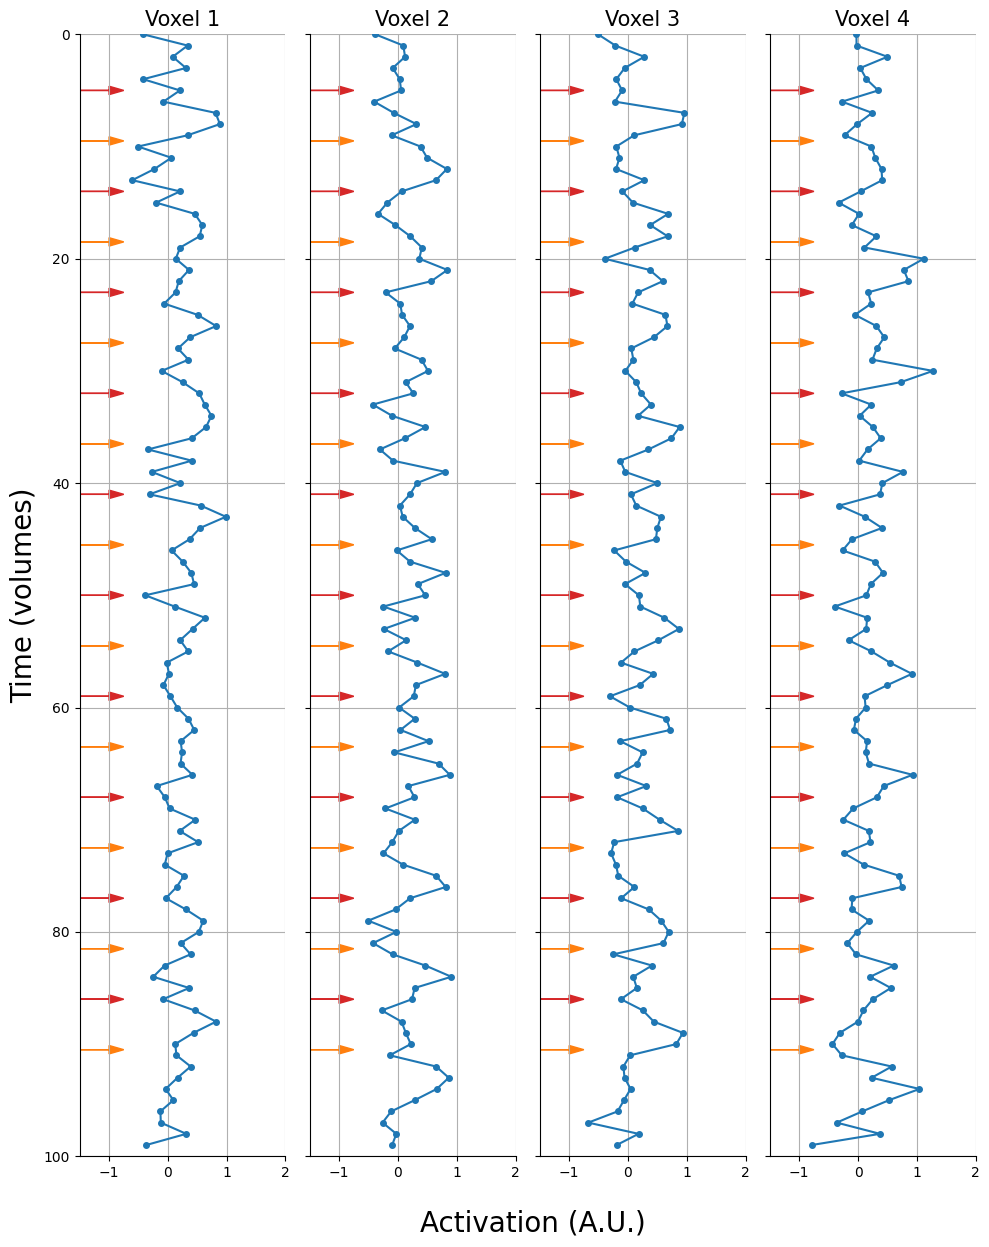

In [22]:
import seaborn as sns

fig, axes = plt.subplots(ncols=K, sharex=True, sharey=True, figsize=(10, 12))
t = np.arange(ts.shape[0])

for i, ax in enumerate(axes.flatten()):
    # Plot signal
    ax.plot(ts[:, i], t, marker='o', ms=4, c='tab:blue')
    # Plot trial onsets (as arrows)
    for ii, to in enumerate(onsets):
        color = 'tab:red' if ii % 2 == 0 else 'tab:orange'
        ax.arrow(-1.5, to / TR, dy=0, dx=0.5, color=color, head_width=0.75, head_length=0.25)

    ax.set_xlim(-1.5, 2)
    ax.set_ylim(0, ts.shape[0])
    ax.grid(visible=True)
    ax.set_title(f'Voxel {i+1}', fontsize=15)
    ax.invert_yaxis()
    if i == 0:
        ax.set_ylabel("Time (volumes)", fontsize=20)
    
# Common axis labels
fig.text(0.425, -.03, "Activation (A.U.)", fontsize=20)
fig.tight_layout()
sns.despine()
plt.show()

<div class='alert alert-success'>
    <b>Tip</b>: Matplotlib is a very flexible plotting package, but arguably at the expense of how fast you can implement something. <a href="https://seaborn.pydata.org/">Seaborn</a> is a great package (build on top of Matplotlib) that offers some neat functionality that makes your life easier when plotting in Python. For example, we used the <tt>despine</tt> function to remove the top and right spines to make our plot a little nicer. In this course, we'll mostly use Matplotlib, but we just wanted to make you aware of this awesome package.
</div>

Alright, now we can start discussing methods for pattern estimation! Unfortunately, as pattern analyses are relatively new, there no concensus yet about the "best" method for pattern estimation. In fact, there exist many different methods, which we can roughly divided into two types:

1. Timepoint-based method (for lack of a better name) and
2. GLM-based methods

We'll discuss both of them, but spend a little more time on the latter set of methods as they are more complicated (and are more popular).

### Timepoint-based methods
Timepoint-based methods "extract" patterns by simply using a single timepoint (e.g., 6 seconds after stimulus presentation) or (an average of) multiple timepoints (e.g., 4, 6, and 8 seconds after stimulus presentation). 

Below, we visualize how a single-timepoint method would look like (assuming that we'd want to extract the timepoint 6 seconds after stimulus presentation, i.e., around the assumed peak of the BOLD response). The stars represent the values that we would extract (red when condition A, orange when condition B). Note, we only plot the first 60 volumes.

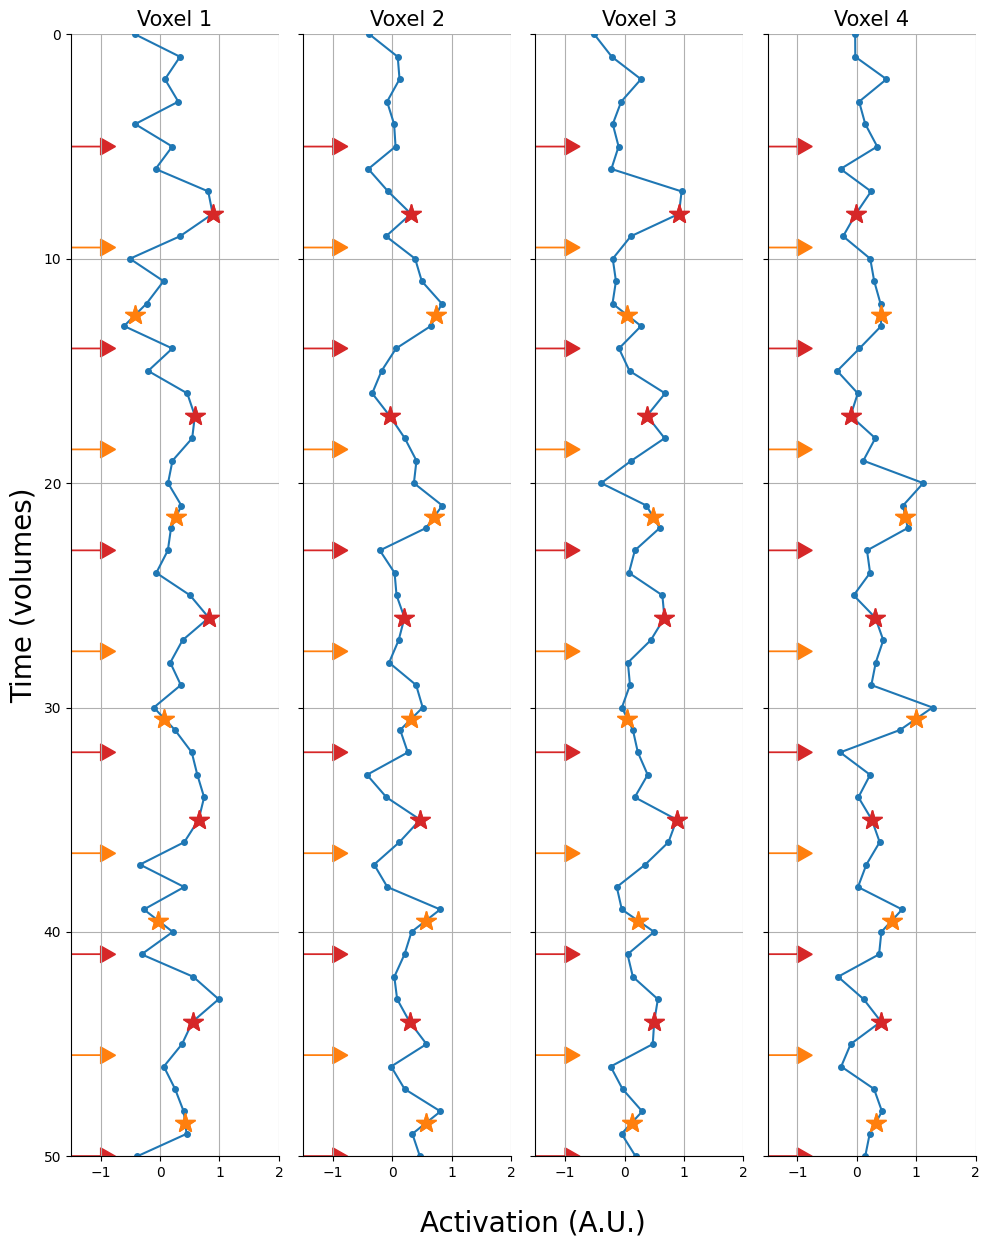

In [23]:
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(10, 12))
t_fmri = np.linspace(0, T, ts.shape[0], endpoint=False)
t = np.arange(ts.shape[0])

for i, ax in enumerate(axes.flatten()):
    # Plot signal
    ax.plot(ts[:, i], t, marker='o', ms=4, c='tab:blue')
    # Plot trial onsets (as arrows)
    for ii, to in enumerate(onsets):
        plus6 = np.interp(to+6, t_fmri, ts[:, i])
        color = 'tab:red' if ii % 2 == 0 else 'tab:orange'
        ax.arrow(-1.5, to / TR, dy=0, dx=0.5, color=color, head_width=0.75, head_length=0.25)
        ax.plot([plus6, plus6], [(to+6) / TR, (to+6) / TR], marker='*', ms=15, c=color)
    
    ax.set_xlim(-1.5, 2)
    ax.set_ylim(0, ts.shape[0] // 2)
    ax.grid(visible=True)
    ax.set_title(f'Voxel {i+1}', fontsize=15)
    ax.invert_yaxis()
    if i == 0:
        ax.set_ylabel("Time (volumes)", fontsize=20)

# Common axis labels
fig.text(0.425, -.03, "Activation (A.U.)", fontsize=20)
fig.tight_layout()
sns.despine()
plt.show()

Now, extracting these timepoints 6 seconds after stimulus presentation is easy when this timepoint is a multiple of the scan's TR (here: 2 seconds). For example, to extract the value for the first trial (onset: 10 seconds), we simply take the 8th value in our timeseries, because $(10 + 6) / 2 = 8$. But what if our trial onset + 6 seconds is *not* a multiple of the TR, such as with trial 2 (onset: 19 seconds)? Well, we can interpolate this value! We will use the same function for this operation as we did for slice-timing correction (from the previous course): `interp1d` from the `scipy.interpolate` module.

To refresh your memory: this function takes the timepoints associated with the values (or "frame_times" in Nilearn lingo) and the values itself to generate a new object which we'll later use to do the actual (linear) interpolation. First, let's define the timepoints:

In [24]:
#T: duration in time. ts: simulated voxel time series
t_fmri = np.linspace(0, T, ts.shape[0], endpoint=False)

For now, let's assume that all data was actually acquired at the start of the volume ($t=0$, $t=2$, etc.). We can "initialize" our interpolator by giving it both the timepoints (`t_fmri`) and the data (`ts`). Note that `ts` is not a single time series, but a 2D array with time series for four voxels (across different columns). By specifying `axis=0`, we tell `interp1d` that the first axis represents the axis that we want to interpolate later:

In [25]:
from scipy.interpolate import interp1d
interpolator = interp1d(t_fmri, ts, axis=0)

Now, we can give the `interpolator` object any set of timepoints and it will return the linearly interpolated values associated with these timepoints for all four voxels. Let's do this for our trial onsets plus six seconds:

Shape extracted pattern: (20, 4)


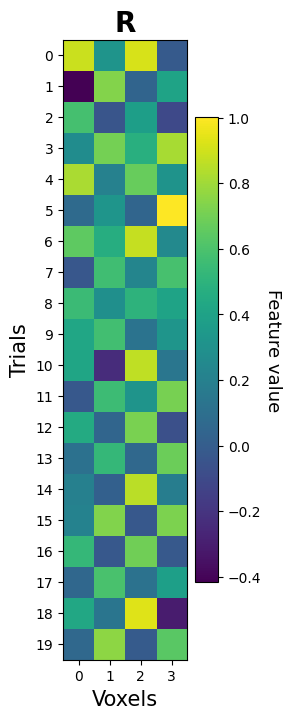

In [26]:
onsets_plus_6 = onsets + 6
R_plus6 = interpolator(onsets_plus_6)
print("Shape extracted pattern:", R_plus6.shape)

fig, ax = plt.subplots(figsize=(2, 10))
mapp = ax.imshow(R_plus6)
cbar = fig.colorbar(mapp)
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=15)
ax.set_yticks(np.arange(N))
ax.set_xticks(np.arange(K))
ax.set_title(r"$\mathbf{R}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()

Yay, we have extracted our first pattern! Does it look like what you expected given the known mean amplitude of the trials from the two conditions ($\beta_{\mathrm{A,even}} = 0.8, \beta_{\mathrm{B,even}} = 0.2$ and vice versa for odd voxels)?

An alternative to the single-timepoint method is to extract, per trial, the <em>average</em> activity within a particular time window, for example 5-7 seconds post-stimulus. One way to do this is by perform interpolation in steps of (for example) 0.1 within the 5-7 post-stimulus time window (i.e., $5.0, 5.1, 5.2, \dots , 6.8, 6.9, 7.0$) and subsequently averaging these values, per trial, into a single activity estimate. Below, we defined these different steps (<tt>t_post_stimulus</tt>). We can then  use the <tt>interpolator</tt> object to extract the timepoints for these different post-stimulus times relative to our onsets (<tt>onsets</tt> variable) from our data (<tt>ts</tt> variable). We will store the extracted patterns in a new variable called <tt>R_av</tt>.

In [27]:

t_post_stimulus = np.linspace(5, 7, 21, endpoint=True)
print(t_post_stimulus)


R_av = np.zeros((onsets.size, K))
for t in t_post_stimulus:
    R_av += interpolator(onsets + t)

R_av /= t_post_stimulus.size

[5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7
 6.8 6.9 7. ]


These timepoint-based methods are relatively simple to implement and computationally efficient. Another variation that you might see in the literature is that extracted (averages of) timepoints are baseline-subtracted ($\mathbf{R}_{i} - \mathrm{baseline}_{i}$) or baseline-normalized ($\frac{\mathbf{R}_{i}}{\mathrm{baseline}_{i}}$), where the baseline is usually chosen to be at the stimulus onset or a small window before the stimulus onset. This technique is, as far as we know, not very popular, so we won't discuss it any further in this lab.

### GLM-based methods
One big disadvantage of timepoint-based methods is that it cannot disentangle activity due to different sources (such as trials that are close in time), which is a major problem for fast (event-related) designs. For example, if you present a trial at $t=10$ and another at $t=12$ and subsequently extract the pattern six seconds post-stimulus (at $t=18$ for the second trial), then the activity estimate for the second trial is definitely going to contain activity due to the first trial because of the sluggishness of the HRF. 

As such, nowadays GLM-based pattern estimation techniques, which *can* disentangle the contribution of different sources, are more popular than timepoint-based methods. (Although, technically, you can use timepoint-based methods using the GLM with FIR-based designs, but that's beyond the scope of this course.) Again, there are multiple flavors of GLM-based pattern estimation, of which we'll discuss the two most popular ones.

#### Least-squares all (LSA)
The most straightforward GLM-based pattern estimation technique is to fit a single GLM with a design matrix that contains one or more regressors for each sample that you want to estimate (in addition to any confound regressors). The estimated parameters ($\hat{\beta}$) corresponding to our samples from this GLM &mdash; representing the relative (de)activation of each voxel for each trial &mdash; will then represent our patterns! 

This technique is often reffered to as "least-squares all" (LSA). Note that, as explained before, a sample can refer to either a single trial, a set of repetitions of a particuar exemplar, or even a single condition. For now, we'll assume that samples refer to single trials. Often, each sample is modelled by a single (canonical) HRF-convolved regressor (but you could also use more than one regressor, e.g., using a basis set with temporal/dispersion derivatives or a FIR-based basis set), so we'll focus on this approach.

Let's go back to our simulated data. We have a single run containing 20 trials, so ultimately our design matrix should contain twenty columns: one for every trial. We can use the `make_first_level_design_matrix` function from Nilearn to create the design matrix. Importantly, we should make sure to give a separate and unique "trial_type" values for all our trials. If we don't do this (e.g., set trial type to the trial condition: "A" or "B"), then Nilearn won't create separate regressors for our trials.

In [9]:
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix

# We have to create a dataframe with onsets/durations/trial_types
# No need for modulation!
events_sim = pd.DataFrame(onsets, columns=['onset'])
events_sim.loc[:, 'duration'] = 1
events_sim.loc[:, 'trial_type'] = ['trial_' + str(i).zfill(2) for i in range(1, N+1)]

# lsa_dm = least squares all design matrix
lsa_dm = make_first_level_design_matrix(
    frame_times=t_fmri,  # we defined this earlier for interpolation!
    events=events_sim,
    hrf_model='glover',
    drift_model=None  # assume data is already high-pass filtered
)

# Check out the created design matrix
# Note that the index represents the frame times
lsa_dm

NameError: name 'onsets' is not defined

Note that the design matrix contains 21 regressors: 20 trialwise regressors and an intercept (the last column). Let's also plot it using Nilearn:

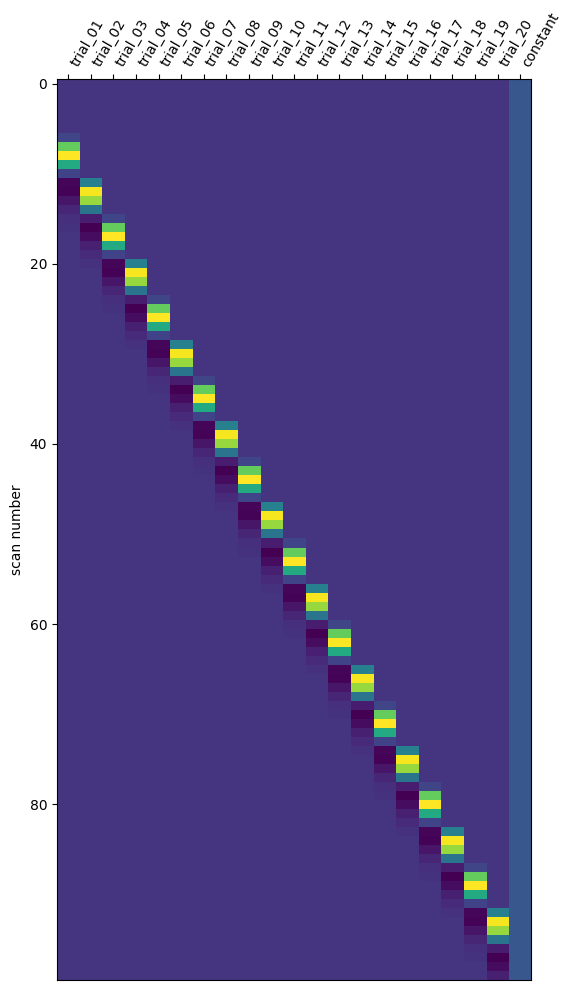

In [29]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(lsa_dm);

And, while we're at it, plot it as time series (rather than a heatmap):

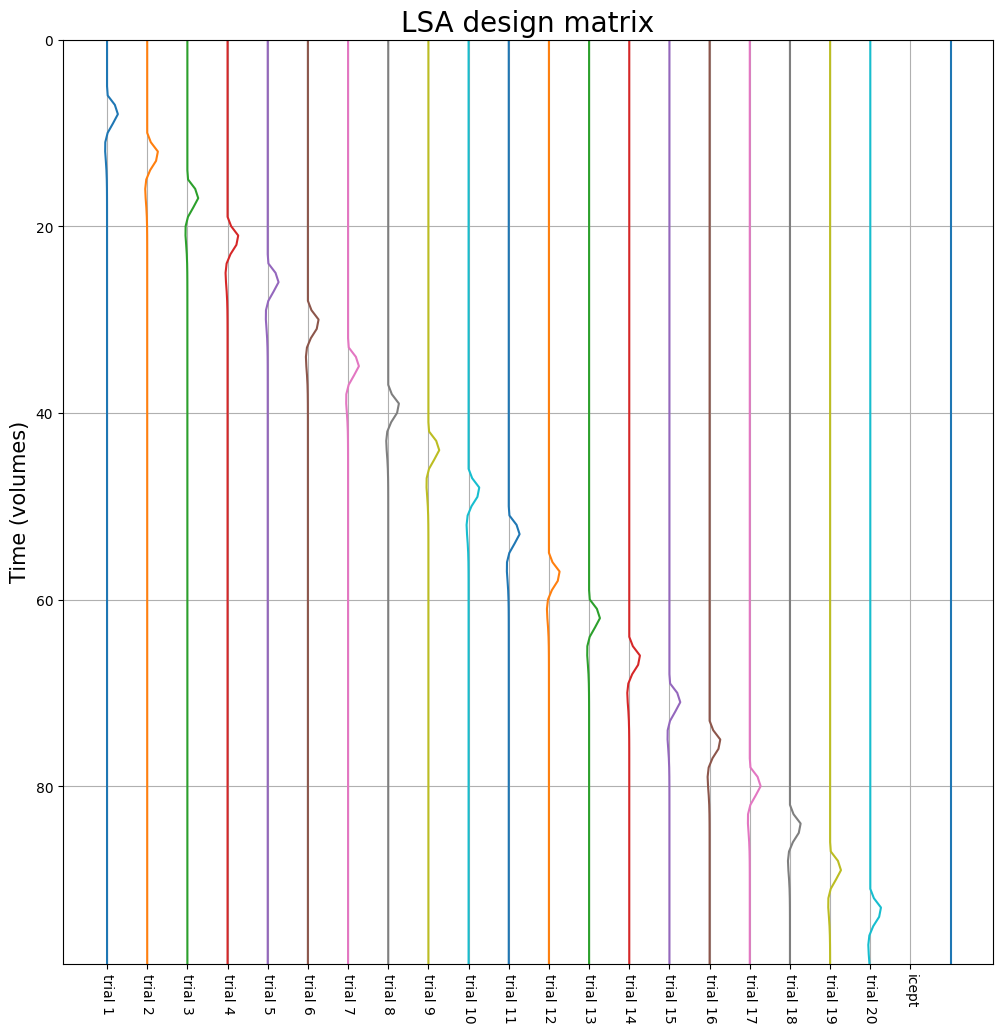

In [30]:
fig, ax = plt.subplots(figsize=(12, 12))
for i in range(lsa_dm.shape[1]):
    ax.plot(i + lsa_dm.iloc[:, i], np.arange(ts.shape[0]))

ax.set_title("LSA design matrix", fontsize=20)
ax.set_ylim(0, lsa_dm.shape[0]-1)
ax.set_xlabel('')
ax.set_xticks(np.arange(N+1))
ax.set_xticklabels(['trial ' +  str(i+1) for i in range(N)] + ['icept'], rotation=-90)
ax.invert_yaxis()
ax.grid()
ax.set_ylabel("Time (volumes)", fontsize=15)
plt.show()

One "problem" with LSA-type design matrices, especially in fast event-related designs, is that they are not very statistically <em>efficient</em>, i.e., they lead to relatively high variance estimates of your parameters ($\hat{\beta}$), mainly due to relatively high predictor variance. Because we used a fixed inter-trial interval (here: 9 seconds), the correlation between "adjacent" trials are (approximately) the same. <br>
    
We can compute the correlation between, for example, the predictors associated with trial 1 and trial 2, using the <tt>pearsonr</tt> function imported below, and store it in a variable named <tt>corr_t1t2</tt>.


In [31]:
# For more info about the `pearsonr` function, check
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
# Want a challenge? Try to compute the correlation from scratch!
from scipy.stats import pearsonr

corr_t1t2 = pearsonr(lsa_dm.iloc[:, 0], lsa_dm.iloc[:, 1])[0]


You could decrease the trial-by-trial correlation by increasing the inter-stimulus interval (at the cost of fewer trials, assuming a fixed run length).

Alright, let's actually fit the model! When dealing with real fMRI data, we'd use Nilearn to fit our GLM, but for now, we'll just use our own implementation of an (OLS) GLM. Note that we can actually fit a *single* GLM for all voxels at the same time by using `ts` (a $T \times K$ matrix) as our dependent variable due to the magic of linear algebra. In other words, we can run $K$ OLS models at once!

In [32]:
# Let's use 'X', because it's shorter
X = lsa_dm.values

# Note we can fit our GLM for all K voxels at 
# the same time! As such, betas is not a vector,
# but an n_regressor x k_voxel matrix!
beta_hat_all = np.linalg.inv(X.T @ X) @ X.T @ ts
print("Shape beta_hat_all:", beta_hat_all.shape)

# Ah, the beta for the intercept is still in there
# Let's remove it
beta_icept = beta_hat_all[-1, :]
beta_hat = beta_hat_all[:-1, :]
print("Shape beta_hat (intercept removed):", beta_hat.shape)

Shape beta_hat_all: (21, 4)
Shape beta_hat (intercept removed): (20, 4)


Alright, let's visualize the estimated parameters ($\hat{\beta}$). We'll do this by plotting the scaled regressors (i.e., $X_{j}\hat{\beta}_{j}$) on top of the original signal. Each differently colored line represents a different regressor (so a different trial):

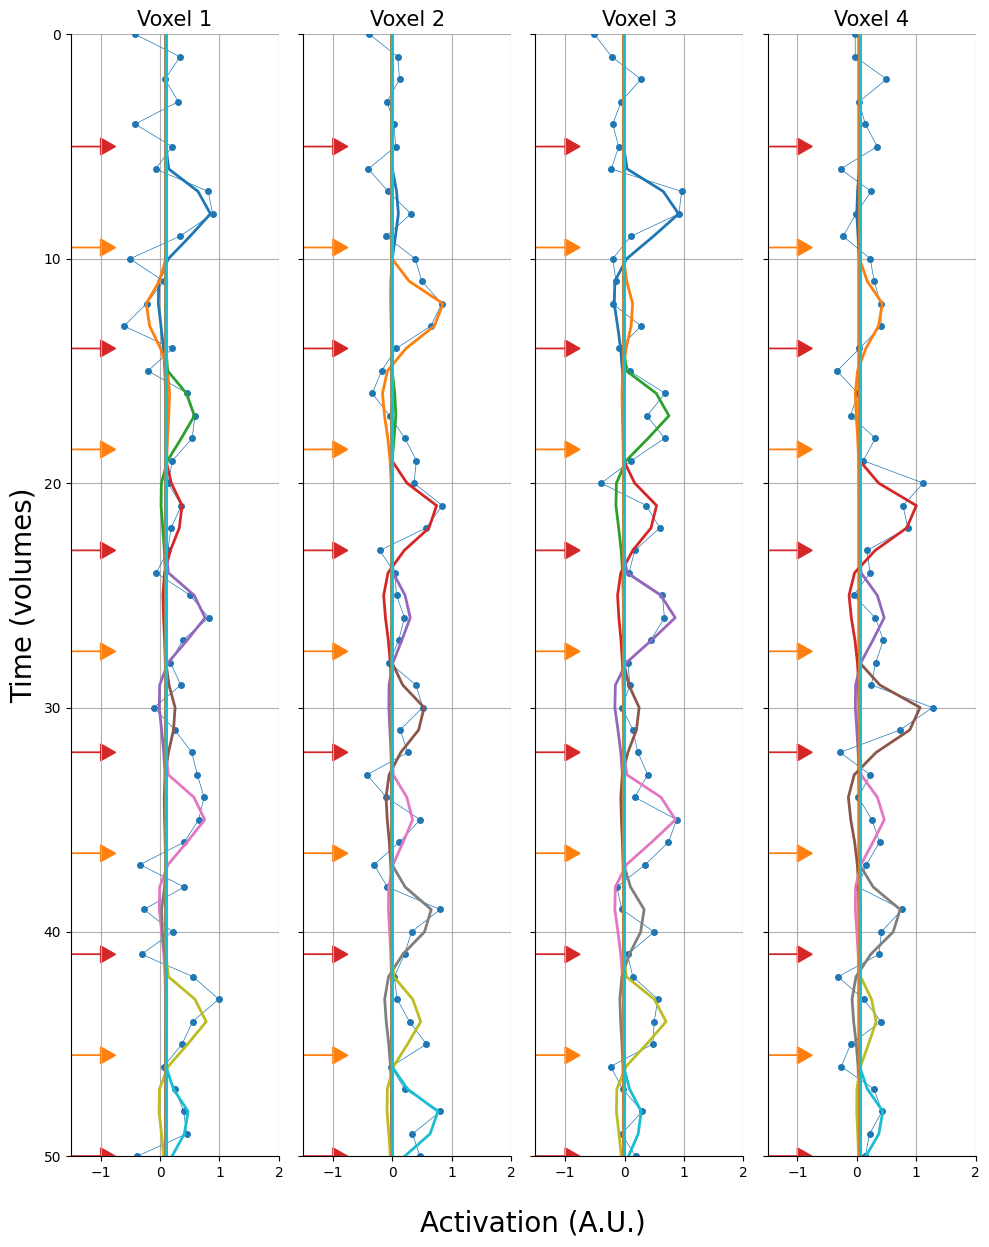

In [34]:
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(10, 12))
t = np.arange(ts.shape[0])

for i, ax in enumerate(axes.flatten()):
    # Plot signal
    ax.plot(ts[:, i], t, marker='o', ms=4, lw=0.5, c='tab:blue')
    # Plot trial onsets (as arrows)
    for ii, to in enumerate(onsets):
        color = 'tab:red' if ii % 2 == 0 else 'tab:orange'
        ax.arrow(-1.5, to / TR, dy=0, dx=0.5, color=color, head_width=0.75, head_length=0.25)

    # Compute x*beta for icept only 
    scaled_icept = lsa_dm.iloc[:, -1].values * beta_icept[i]
    for ii in range(N):
        this_x = lsa_dm.iloc[:, ii].values
        # Compute x*beta for this particular trial (ii)
        xb = scaled_icept + this_x * beta_hat[ii, i]
        ax.plot(xb, t, lw=2)

    ax.set_xlim(-1.5, 2)
    ax.set_ylim(0, ts.shape[0] // 2)
    ax.grid(visible=True)
    ax.set_title(f'Voxel {i+1}', fontsize=15)
    ax.invert_yaxis()
    if i == 0:
        ax.set_ylabel("Time (volumes)", fontsize=20)

# Common axis labels
fig.text(0.425, -.03, "Activation (A.U.)", fontsize=20)
fig.tight_layout()
sns.despine()
plt.show()

Ultimately, though, the estimated GLM parameters are just another way to estimate our pattern array ($\mathbf{R}$) &mdash; this time, we just estimated it using a different method (GLM-based) than before (timepoint-based). Therefore, let's visualize this array as we did with the other methods:

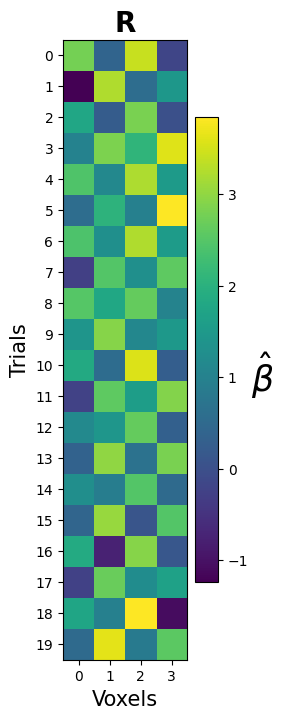

In [35]:
fig, ax = plt.subplots(figsize=(2, 10))
mapp = ax.imshow(beta_hat)
cbar = fig.colorbar(mapp)
cbar.set_label(r'$\hat{\beta}$', fontsize=25, rotation=0, labelpad=10)
ax.set_yticks(np.arange(N))
ax.set_xticks(np.arange(K))
ax.set_title(r"$\mathbf{R}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()

### Noise normalization
One often used preprocessing step for pattern analyses (using GLM-estimation methods) is to use "noise normalization" on the estimated patterns. There are two flavours: "univariate" and "multivariate" noise normalization. In univariate noise normalization, the estimated parameters ($\hat{\beta}$) are divided (normalized) by the standard deviation of the estimated parameters &mdash; which you might recognize as the formula for $t$-values (for a contrast against baseline)!

\begin{align}
t_{c\hat{\beta}} = \frac{c\hat{\beta}}{\sqrt{\hat{\sigma}^{2}c(X^{T}X)^{-1}c^{T}}}
\end{align}

where $\hat{\sigma}^{2}$ is the estimate of the error variance (sum of squared errors divided by the degrees of freedom) and $c(X^{T}X)^{-1}c^{T}$ is the "design variance". Sometimes people disregard the design variance and the degrees of freedom (DF) and instead only use the standard deviation of the noise: 

\begin{align}
t_{c\hat{\beta}} \approx \frac{c\hat{\beta}}{\sqrt{\sum (y_{i} - X_{i}\hat{\beta})^{2}}}
\end{align}

<div class='alert alert-info'>
    <b>ToThink</b>: When experiments use a fixed ISI (in the context of single-trial GLMs), the omission of the design variance in univariate noise normalization is warranted. Explain why.
</div>

When there is a fixed ISI, the (co)variance of each trial is the same, so the design variance is (approximately) the same for each trial and can thus be left out. 

Either way, this univariate noise normalization is a way to "down-weigh" the uncertain (noisy) parameter estimates. Although this type of univariate noise normalization seems to lead to better results in both decoding and RSA analyses (e.g., [Misaki et al., 2010](https://www.ncbi.nlm.nih.gov/pubmed/20580933)), the jury is still out on this issue.

Multivariate noise normalization will be discussed in week 3 (RSA), so let's focus for now on the implementation of univariate noise normalization using the approximate method (which disregards design variance). To compute the standard deviation of the noise ($\sqrt{\sum (y_{i} - X_{i}\hat{\beta})^{2}}$), we first need to compute the noise, i.e., the unexplained variance ($y - X\hat{\beta}$) also known as the residuals:

In [36]:
residuals = ts - X @ beta_hat_all
print("Shape residuals:", residuals.shape)

Shape residuals: (100, 4)


So, for each voxel ($K=4$), we have a timeseries ($T=100$) with unexplained variance ("noise"). Now, to get the standard deviation across all voxels, we can do the following:

In [37]:
std_noise = np.std(residuals, axis=0)
print("Shape noise std:", std_noise.shape)

Shape noise std: (4,)


To do the actual normalization step, we simply divide the columns of the pattern matrix (`beta_hat`, which we estimated before) by the estimated noise standard deviation:

In [38]:
# unn = univariate noise normalization
# Note that we don't have to do this for each trial (row) separately
# due to Numpy broadcasting!
R_unn = beta_hat / std_noise
print("Shape R_unn:", R_unn.shape)

Shape R_unn: (20, 4)


And let's visualize it:

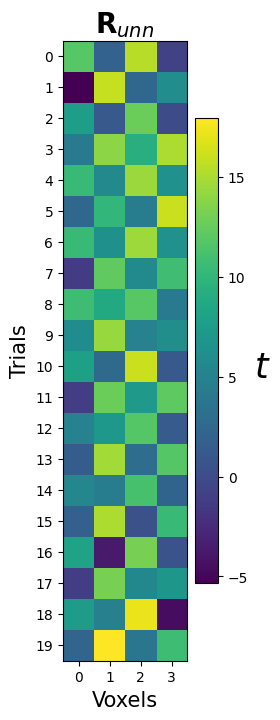

In [39]:
fig, ax = plt.subplots(figsize=(2, 10))
mapp = ax.imshow(R_unn)
cbar = fig.colorbar(mapp)
cbar.set_label(r'$t$', fontsize=25, rotation=0, labelpad=10)
ax.set_yticks(np.arange(N))
ax.set_xticks(np.arange(K))
ax.set_title(r"$\mathbf{R}_{unn}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()

In fact, univariate noise normalization didn't really change the pattern matrix much. Why do you think this is the case for our simulation data? 

We simulated the data which an equal noise standard deviation (`std_noise` parameter) for each voxel! In real data, this will probably differ across voxels!

### Now, let's classify

We will use one of the classifiers, we introduced above. We will pick the `GaussianNB`classifier. The [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) is nice because it is fairly easy to understand (although actually explaining it is beyond this course).



In [102]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X=R_unn
y=conditions    

# We will use these classifiers, just to illustrate the varieties
classifier = GaussianNB()
#clf=[name,classifier]

X = StandardScaler().fit_transform(X)
#Divide the training set and test set into equal sizes.
X_train, X_test, y_train, y_test = \
   train_test_split(X, y, test_size=.5, random_state=42)
#Fit the training data
classifier.fit(X_train, y_train)
#Predict the test data, get score
score = classifier.score(X_test, y_test)
print(score)

NameError: name 'R_unn' is not defined

That went well. 100% correct. Life is easy with simulated data.

<div class='alert alert-warning'>
    <b>ToDo</b> : Try changing the simulated signal contrast using the "param_even" variable where we defined the signal above. Try changing the "test_size" in the classification as well to see if that makes a difference. You can also try a different classifier.
</div>

## LSA on real data
Alright, enough with all that fake data &mdash; let's work with some real data! We'll use the face perception task data from the *NI-edu* dataset, which we briefly mentioned in the fMRI-introduction course.

In the face perception task, participants were presented with images of faces (from the publicly available [Face Research Lab London Set](https://figshare.com/articles/Face_Research_Lab_London_Set/5047666)). In total, frontal face images from 40 different people ("identities") were used, which were either without expression ("neutral") or were smiling. Each face image (from in total 80 faces, i.e., 40 identities $\times$ 2, neutral/smiling) was shown, per participant, 6 times across the 12 runs (3 times per session). 

<div class='alert alert-info'>
    <b>Mini ToThink</b>: Why do you think we show the same image multiple times?
</div>

Identities were counterbalanced in terms of biological sex (male vs. female) and ethnicity (Caucasian vs. East-Asian vs. Black). The Face Research Lab London Set also contains the age of the people in the stimulus dataset and (average) attractiveness ratings for all faces from an independent set of raters. In addition, we also had our own participants rate the faces on perceived attractiveness, dominance, and trustworthiness after each session (rating each face, on each dimension, four times in total for robustness). The stimuli were chosen such that we have many different attributes that we could use to model brain responses (e.g., identity, expression, ethnicity, age, average attractiveness, and subjective/personal perceived attractiveness/dominance/trustworthiness).

In this paradigm, stimuli were presented for 1.25 seconds and had a fixed interstimulus interval (ISI) of 3.75 seconds. While sub-optimal for univariate "detection-based" analyses, we used a fixed ISI &mdash; rather than jittered &mdash; to make sure it can also be used for "single-trial" multivariate analyses. Each run contained 40 stimulus presentations. To keep the participants attentive, a random selection of 5 stimuli (out of 40) were followed by a rating on either perceived attractiveness, dominance, or trustworthiness using a button-box with eight buttons (four per hand) lasting 2.5 seconds. After the rating, a regular ISI of 3.75 seconds followed. See the figure below for a visualization of the paradigm.

![face_paradigm](https://docs.google.com/drawings/d/e/2PACX-1vQ0FlwZLI_XMHaKkaNchzZvgqT0JXjZAPbH9fccmNvgey-RYR5bKolh85Wctc2YLrjOLtE3Zkd7WXdu/pub?w=1429&h=502)

First, let's set up all the data that we need for our LSA model. Let's see where our data is located:

In [5]:
import os

data_dir = os.path.join(os.path.expanduser('~'), 'NI-edu-data')

print("Downloading Fmriprep data (+- 175MB) ...\n")
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "sub-03/ses-1/func/*task-face*run-1*events.tsv"
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "derivatives/fmriprep/sub-03/ses-1/func/*task-face*run-1*space-T1w*bold.nii.gz"
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "derivatives/fmriprep/sub-03/ses-1/func/*task-face*run-1*space-T1w*mask.nii.gz"
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "derivatives/fmriprep/sub-03/ses-1/func/*task-face*run-1*confounds_timeseries.tsv"
print("\nDone!")



Done!


As you can see, it contains both "raw" (not-preprocessed) subject data (e.g., sub-03) and derivatives, which include Fmriprep-preprocessed data:

In [6]:
fprep_sub03 = os.path.join(data_dir, 'derivatives', 'fmriprep', 'sub-03')
print("Contents derivatives/fmriprep/sub-03:", os.listdir(fprep_sub03))

Contents derivatives/fmriprep/sub-03: ['ses-1']


There is preprocessed anatomical data and session-specific functional data:

In [7]:
fprep_sub03_ses1_func = os.path.join(fprep_sub03, 'ses-1', 'func')
contents = sorted(os.listdir(fprep_sub03_ses1_func))
print("Contents ses-1/func:", '\n'.join(contents))

Contents ses-1/func: sub-03_ses-1_task-face_run-1_desc-confounds_timeseries.tsv
sub-03_ses-1_task-face_run-1_space-T1w_desc-brain_mask.nii.gz
sub-03_ses-1_task-face_run-1_space-T1w_desc-preproc_bold.nii.gz


That's a lot of data! Importantly, we will only use the "face" data ("task-face") in T1 space ("space-T1w"), meaning that this data has not been normalized to a common template (unlike the "task-MNI152NLin2009cAsym" data). Here, we'll only analyze the first run ("run-1") data. Let's define the functional data, the associated functional brain mask (a binary image indicating which voxels are brain and which are not), and the file with timepoint-by-timepoint confounds (such as motion parameters):

In [10]:
func = os.path.join(fprep_sub03_ses1_func, 'sub-03_ses-1_task-face_run-1_space-T1w_desc-preproc_bold.nii.gz')

# Notice this neat little trick: we use the string method "replace" to define
# the functional brain mask
func_mask = func.replace('desc-preproc_bold', 'desc-brain_mask')

#Make a data frame with confounds
confs = os.path.join(fprep_sub03_ses1_func, 'sub-03_ses-1_task-face_run-1_desc-confounds_timeseries.tsv')
confs_df = pd.read_csv(confs, sep='\t')
confs_df

,global_signal,global_signal_derivative1,global_signal_derivative1_power2,global_signal_power2,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,...,rot_x_derivative1_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,motion_outlier00
0,32452.228653,NaN,NaN,1.053147e+09,56448.645321,NaN,NaN,3.186450e+09,33477.742348,NaN,...,NaN,-0.000291,NaN,NaN,8.450358e-08,0.000421,NaN,1.770558e-07,NaN,0.0
1,32374.326829,-77.901823,6068.694064,1.048097e+09,55903.557212,-545.088109,297121.046798,3.125208e+09,33461.938656,-15.803692,...,5.203235e-46,0.000048,3.383386e-04,1.144730e-07,2.269913e-09,0.000000,-0.000421,0.000000e+00,1.770558e-07,0.0
2,32328.138891,-46.187938,2133.325610,1.045109e+09,55694.677005,-208.880207,43630.940942,3.101897e+09,33447.470231,-14.468426,...,1.588104e-08,0.000048,-4.410000e-08,1.944810e-15,2.265712e-09,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
3,32310.910024,-17.228868,296.833887,1.043995e+09,55575.853868,-118.823136,14118.937749,3.088676e+09,33432.562277,-14.907954,...,4.992468e-07,0.000490,4.422145e-04,1.955537e-07,2.399178e-07,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
4,32294.584213,-16.325811,266.532092,1.042940e+09,55408.908249,-166.945619,27870.839776,3.070147e+09,33414.449996,-18.112281,...,1.071489e-07,-0.000084,-5.736183e-04,3.290380e-07,7.023161e-09,0.000170,0.000170,2.889184e-08,2.889184e-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,31946.939473,-20.991637,440.648839,1.020607e+09,55087.811985,-49.086685,2409.502635,3.034667e+09,33105.711432,-29.471095,...,5.920900e-08,0.000089,-2.001220e-04,4.004881e-08,7.944692e-09,-0.000059,-0.000192,3.490033e-09,3.705336e-08,0.0
338,31950.066021,3.126548,9.775302,1.020807e+09,55027.153585,-60.658401,3679.441558,3.027988e+09,33103.520451,-2.190981,...,1.318576e-07,0.000089,0.000000e+00,0.000000e+00,7.944692e-09,0.000034,0.000093,1.148071e-09,8.641506e-09,0.0
339,31944.702633,-5.363388,28.765934,1.020464e+09,55133.790131,106.636546,11371.352943,3.039735e+09,33008.779629,-94.740822,...,4.723668e-08,0.000089,0.000000e+00,0.000000e+00,7.944692e-09,-0.000059,-0.000093,3.490033e-09,8.641506e-09,0.0
340,31947.495584,2.792952,7.800578,1.020642e+09,55189.106597,55.316466,3059.911431,3.045837e+09,33106.108555,97.328926,...,1.424617e-07,0.000280,1.908810e-04,3.643556e-08,7.840784e-08,0.000052,0.000112,2.749849e-09,1.243571e-08,0.0


Finally, we need the events-file with onsets, durations, and trial-types for this particular run:

In [75]:
#Make a data frame with experimental events
events = os.path.join(data_dir, 'sub-03', 'ses-1', 'func', 'sub-03_ses-1_task-face_run-1_events.tsv')
events_df = pd.read_csv(events, sep='\t')
events_df = events_df.query("trial_type != 'rating' and trial_type != 'response'")  # don't need this

# Oops, Nilearn doesn't accept trial_type values that start with a number, so
# let's prepend 'tt_' to it!
events_df['trial_type'] = 'tt_' + events_df['trial_type']



Now, let's go to work on these data frames:
First, we will define the events and the confounds we want to include.
    
1. Remove all columns except "onset", "duration", and "trial_type". We should end up with a DataFrame with 40 rows and 3 columns. We can check this with the <tt>.shape</tt> attribute of the DataFrame. (Note that, technically, we could model the reponse and rating-related events as well! For now, we'll exclude them.) 

2. We will name this filtered DataFrame <tt>events_df_filt</tt>.
    
3. We will also need to select specific columns from the confounds DataFrame, as we don't want to include <em>all</em> confounds! For now, include only the motion parameters (<tt>trans_x, trans_y, trans_z, rot_x, rot_y, rot_z</tt>). We should end up with a confounds DataFrame with 342 rows and 6 columns. 

4. We will name this filtered DataFrame <tt>confs_df_filt</tt>.


In [76]:
events_df_filt = events_df.query("trial_type != 'response' and trial_type != 'rating'")
events_df_filt = events_df_filt.loc[:, ['onset', 'duration', 'trial_type']]
confs_df_filt = confs_df.loc[:, ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]

##Check dataframes if you want:
print(events_df_filt)
print(confs_df_filt.shape)


         onset  duration           trial_type
0     6.022445  1.233307  tt_00STIM117smiling
1    11.022318  1.233310  tt_01STIM027smiling
2    16.022165  1.233322  tt_02STIM027neutral
3    21.022053  1.233282  tt_03STIM092smiling
4    26.021899  1.233297  tt_04STIM066neutral
5    31.021738  1.233324  tt_05STIM092neutral
6    36.021618  1.233313  tt_06STIM061smiling
7    41.021482  1.233311  tt_07STIM101neutral
8    46.021346  1.233311  tt_08STIM062smiling
9    51.021228  1.233279  tt_09STIM137neutral
12   60.020963  1.233313  tt_10STIM141smiling
15   69.012388  1.241642  tt_11STIM030neutral
16   74.012240  1.241653  tt_12STIM100neutral
17   79.012104  1.241649  tt_13STIM091neutral
18   84.020339  1.233276  tt_14STIM038smiling
19   89.020173  1.233305  tt_15STIM082smiling
20   94.020035  1.233300  tt_16STIM124neutral
21   99.019894  1.233310  tt_17STIM006smiling
22  104.019757  1.233330  tt_18STIM036smiling
23  109.019625  1.233305  tt_19STIM102neutral
24  114.019502  1.233330  tt_20STI

NB. Note that the <tt>trial_type<tt/> value is different for all events. When we fit a model with these discriptions, this means that they will be put into different columns in the design matrix.

#### Makng the model

Next we'll fit our model! We will define a <tt>FirstLevelModel</tt> object, name this <tt>flm_face</tt> and make sure we do the following:<br>
    
1. Set the correct TR (this is 0.7)
2. Set the slice time reference to 0.5
3. Set the mask image to the one we defined before
4. Use a "glover" HRF
5. Use a "cosine" drift model with a cutoff of 0.01 Hz
6. Do not apply any smoothing
7. Set minimize_memory to true
8. Use an "ols" noise model

Then, we will fit our model using the functional data (<tt>func</tt>), filtered confounds, and filtered events we defined before. 

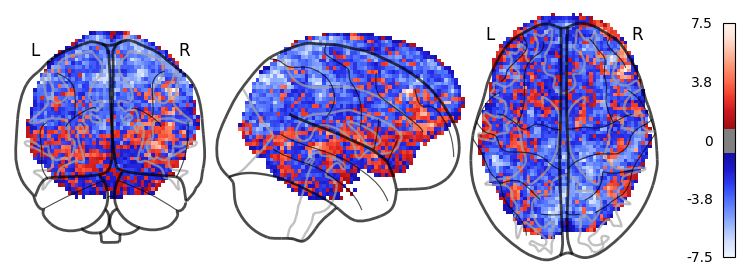

In [69]:
# Ignore the DeprecationWarning!
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting

flm_face = FirstLevelModel(
    t_r=0.7,
    slice_time_ref=0.5,
    mask_img=func_mask,
    hrf_model='glover',
    drift_model='cosine',
    high_pass=0.01,
    smoothing_fwhm=None,
    minimize_memory=True,
    noise_model='ols'
)
flm_face.fit(func, events=events_df_filt, confounds=confs_df_filt);

#Making a contrast with the first trial - note data not in standard space
tmap = flm_face.compute_contrast('tt_00STIM117smiling')
plotting.plot_glass_brain(tmap, cmap='blue_red',colorbar=True,
                        plot_abs=False)


Now, we'll run the single-trial contrasts ("against baseline"). To do so, we write a for-loop in which you call the <tt>compute_contrast</tt> method every iteration with a new contrast definition for a new trial. We'll make sure to output the "betas" (by using <tt>output_type='effect_size'</tt>).
    
Note that the <tt>compute_contrast</tt> method returns the "unmasked" results (i.e., from all voxels). We therefore have to make sure that, for each trial, we mask the results using the <tt>func_mask</tt> variable and the <tt>apply_mask</tt> function from Nilearn. Save these masked results (which should be patterns of 66298 voxels) for each trial. After the loop, we'll stack all results in a 2D array with the different trials in different rows and the (flattened) voxels in columns. This array should be of shape 40 (trials) by 65643 (nr. of masked voxels). The variable name of this array should be <tt>R_face</tt>.


In [70]:
from nilearn.masking import apply_mask

R_face = []
for col in events_df_filt['trial_type']:
    img = flm_face.compute_contrast(col, output_type='effect_size')
    R_face.append(apply_mask(img, func_mask))
    
R_face = np.vstack(R_face)


<div class='alert alert-success'>
    <b>Disclaimer</b>: Here, we did <em>not</em> spatially smooth the data. Not doing this is often recommended for pattern analyses, as they arguably use information that is encoded in finely distributed patterns. However, several studies have shown that smoothing may sometimes benefit pattern analyses (e.g., <a href="https://www.frontiersin.org/articles/10.3389/fneur.2017.00222/full">Hendriks et al., 2017</a>). In general, in line with the <a href="https://en.wikipedia.org/wiki/Matched_filter">matched filter theorem</a>, we recommend smoothing your data with a kernel equal to how finegrained you think your experimental feature is encoded in the brain patterns.
</div>

## Dealing with trial correlations
When working with single-trial experimental designs (such as the LSA designs discussed previously), one often occurring problem is correlation between trial predictors and their resulting estimates. Trial correlations in such designs occur when the inter-stimulus interval (ISI) is sufficiently short such that trial predictors overlap and thus correlate. This, in turn, leads to relatively unstable (high-variance) pattern estimates and, as we will see later in this section, trial patterns that correlate with each other (which is sometimes called [pattern drift](https://www.biorxiv.org/content/10.1101/032391v2)).

This is also the case in our data from the NI-edu dataset. In the "face" task, stimuli were presented for 1.25 seconds, followed by a 3.75 ISI, which causes a slightly positive correlation between a given trial ($i$) and the next trial ($i + 1$) and a slightly negative correlation between the trial after that ($i + 2$). We'll show this below by visualizing the correlation matrix of the design matrix: 

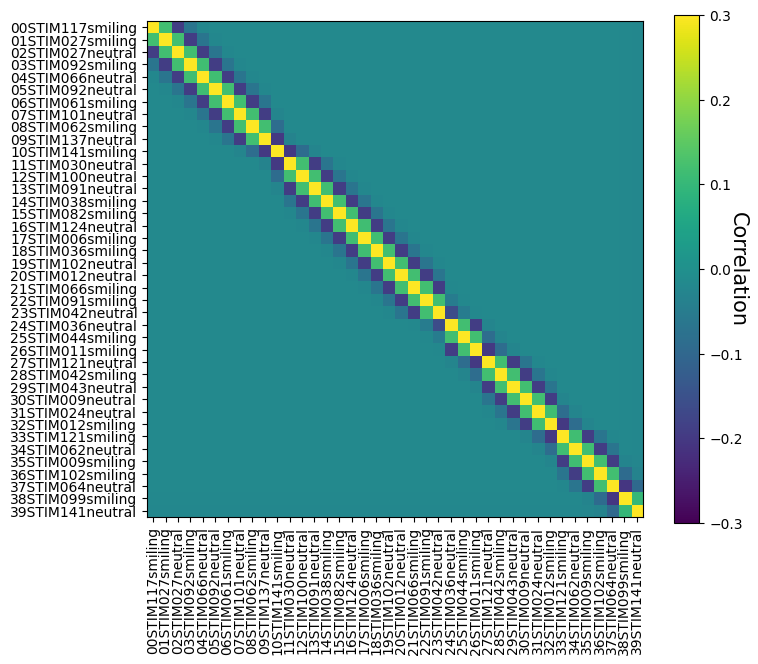

In [71]:
dm_face = pd.read_csv('data/dm_face.tsv', sep='\t')
dm_face = dm_face.iloc[:, :40]
fig, ax = plt.subplots(figsize=(8, 8))

# Slightly exaggerate by setting the limits to (-.3, .3)
mapp = ax.imshow(dm_face.corr(), vmin=-0.3, vmax=0.3)

# Some styling
ax.set_xticks(range(dm_face.shape[1]))
ax.set_xticklabels(dm_face.columns, rotation=90)
ax.set_yticks(range(dm_face.shape[1]))
ax.set_yticklabels(dm_face.columns)
cbar = plt.colorbar(mapp, shrink=0.825)
cbar.ax.set_ylabel('Correlation', fontsize=15, rotation=-90)

plt.show()

<div class='alert alert-info'>
    <b>ToThink</b> (1 point): Explain why trials (at index $i$) correlate slightly <em>negatively</em> with the the second trial coming after it (at index $i + 2$). Hint: try to plot it!
</div>

The undershoot of the current trial occurs simultaneously with the overshoot of the second trial after it.

The trial-by-trial correlation structure in the design leads to a trial-by-trial correlation structure in the estimated patterns as well (as explained by [Soch et al., 2020](https://www.sciencedirect.com/science/article/pii/S1053811919310407)). We show this below by computing and visualizing the $N \times N$ correlation matrix of the patterns:

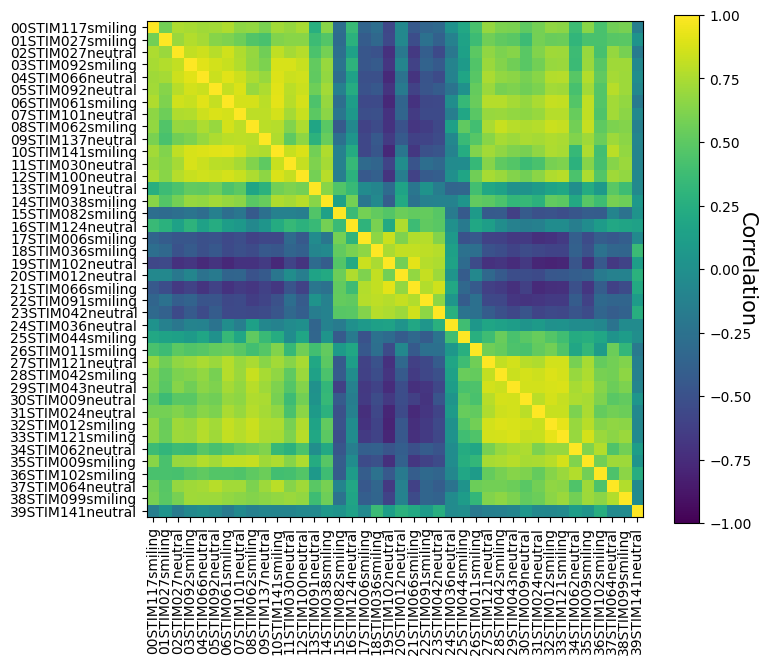

In [72]:
# Load in R_face if you didn't manage to do the
# previous ToDo
R_face = np.load('data/R_face.npy')

# Compute the NxN correlation matrix
R_corr = np.corrcoef(R_face)

fig, ax = plt.subplots(figsize=(8, 8))
mapp = ax.imshow(R_corr, vmin=-1, vmax=1)

# Some styling
ax.set_xticks(range(dm_face.shape[1]))
ax.set_xticklabels(dm_face.columns, rotation=90)
ax.set_yticks(range(dm_face.shape[1]))
ax.set_yticklabels(dm_face.columns)
cbar = plt.colorbar(mapp, shrink=0.825)
cbar.ax.set_ylabel('Correlation', fontsize=15, rotation=-90)

plt.show()

This correlation structure across trials poses a problem for representational similarity and network analyses. Although this issue is still debated and far from solved, in this section we highlight two possible solutions to this problem: least-squares separate designs and temporal "uncorrelation".

### Least-squares separate (LSS)
The least-squares separate LSS) design is a slight modifcation of the LSA design ([Mumford et al., 2014](https://www.sciencedirect.com/science/article/pii/S105381191400768X)). In LSS, you fit a separate model per trial. Each model contains one regressor for the trial that you want to estimate and, for each condition in your experimental design (in case of a categorical design), another regressor containing all other trials. 

So, suppose you have a run with 30 trials across 3 conditions (A, B, and C); using an LSS approach, you'd fit 30 different models, each containing four regressors (one for the single trial, one for all (other) trials of condition A, one for all (other) trials of condition B, and one for all (other) trials of condition C). The apparent upside of this is that it strongly reduces the collinearity of trials close in time, which in turn makes the trial parameters more efficient to estimate.

<div class='alert alert-info'>
    <b>ToThink</b> (1 point): Suppose my experiment contains 90 stimuli which all belong to their own condition (i.e., there are 90 conditions). Explain why LSS provides no improvement over LSA in this case.
</div>

The procedure is exactly the same as an LSA design!

We'll show this for our example data. It's a bit complicated (and not necessarily the best/fastest/clearest way), but the comments will explain what it's doing. Essentially, what we're doing, for each trial, is to extract that regressor for a standard LSA design and, for each condition, create a single regressor by summing all single-trial regressors from that condition together.

In [77]:
t_face = np.linspace(0, flm_face.t_r*len(confs_df_filt),len(confs_df_filt), endpoint=False)
events_df_filt2=events_df_filt.copy()
events_df_filt2['trial_type'] =  events_df_filt2['trial_type'].str.slice(12)
print(events_df_filt2)

         onset  duration trial_type
0     6.022445  1.233307    smiling
1    11.022318  1.233310    smiling
2    16.022165  1.233322    neutral
3    21.022053  1.233282    smiling
4    26.021899  1.233297    neutral
5    31.021738  1.233324    neutral
6    36.021618  1.233313    smiling
7    41.021482  1.233311    neutral
8    46.021346  1.233311    smiling
9    51.021228  1.233279    neutral
12   60.020963  1.233313    smiling
15   69.012388  1.241642    neutral
16   74.012240  1.241653    neutral
17   79.012104  1.241649    neutral
18   84.020339  1.233276    smiling
19   89.020173  1.233305    smiling
20   94.020035  1.233300    neutral
21   99.019894  1.233310    smiling
22  104.019757  1.233330    smiling
23  109.019625  1.233305    neutral
24  114.019502  1.233330    neutral
25  119.019367  1.233296    smiling
26  124.019221  1.233300    smiling
27  129.019086  1.233295    neutral
28  140.268799  1.233281    neutral
29  145.268632  1.233296    smiling
30  150.268493  1.233348    

In [93]:
# First, well make a standard LSA design matrix

# The time frame variable divides scan time up into TRs
t_face = np.linspace(0, flm_face.t_r*len(confs_df_filt),len(confs_df_filt), endpoint=False)
events_df_filt2=events_df_filt.copy()
events_df_filt2['trial_type'] =  events_df_filt2['trial_type'].str.slice(12)
#print(events_df_filt2)

lsa_dm = make_first_level_design_matrix(
    frame_times=t_face,  # we defined this earlier for interpolation!
    events=events_df_filt,
    hrf_model='glover',
    drift_model=None  # assume data is already high-pass filtered
)

# Then, we will loop across trials, making a single GLM
lss_dms = []  # we'll store the design matrices here

# Do not include last column, the intercept, in the loop
for i, col in enumerate(lsa_dm.columns[:-1]):    
    # Extract the single-trial predictor
    single_trial_reg = lsa_dm.loc[:, col]

    # Now, we need to create a predictor per condition
    # (one for smiling, one for neutral). We'll store these in "other_regs"
    other_regs = []

    # Loop across unique conditions ("smiling" and "neutral")
    for con in np.unique(events_df_filt2['trial_type']):
        
        # Which columns belong to the current condition?
        
        idx =  con== np.array(events_df_filt2['trial_type'])

        # Make sure NOT to include the trial we're currently estimating!
        idx[i] = False
        
        # Also, exclude the intercept (last column)
        idx = np.append(idx, False)
        
        # Now, extract all N-1 regressors
        con_regs = lsa_dm.loc[:, idx]
        
        # And sum them together!
        # This creates a single predictor for the current
        # condition
        con_reg_all = con_regs.sum(axis=1)
            
        # Save for later
        other_regs.append(con_reg_all)

    # Concatenate the condition regressors (one of smiling, one for neutral)
    other_regs = pd.concat(other_regs, axis=1)
    
    # Concatenate the single-trial regressor and two condition regressors
    this_dm = pd.concat((single_trial_reg, other_regs), axis=1)

    # Add back an intercept!
    this_dm.loc[:, 'intercept'] = 1
    
    # Give it sensible column names
    this_dm.columns = ['trial_to_estimate'] + list(set(events_df_filt2['trial_type'])) + ['intercept']

    # Save for alter
    lss_dms.append(this_dm)

print("We have created %i design matrices!" % len(lss_dms))

We have created 40 design matrices!


Alright, now let's check out the first five design matrices, which should estimate the first five trials and contain 4 regressors each (one for the single trial, two for the separate conditions, and one for the intercept):

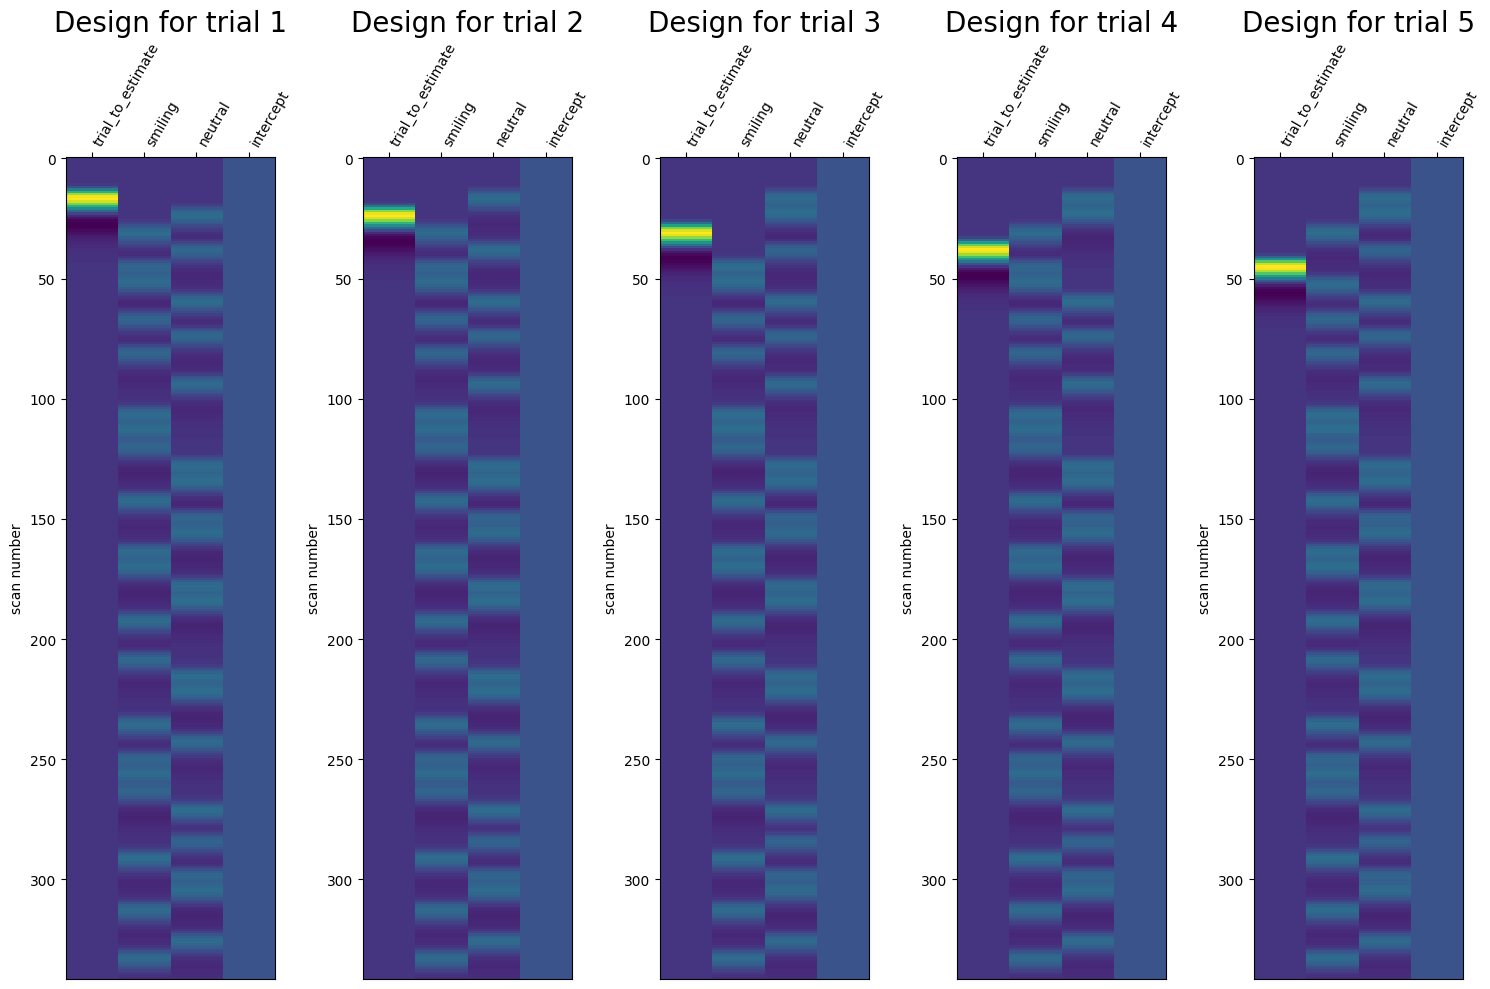

In [94]:
from nilearn.plotting import plot_design_matrix

fig, axes = plt.subplots(ncols=5, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    plot_design_matrix(lss_dms[i], ax=ax)
    ax.set_title("Design for trial %i" % (i+1), fontsize=20)

plt.tight_layout()
plt.show()

We can implement an LSS approach to estimate our patterns on the real data. We can reuse the <tt>flm_face</tt> you created earlier; the only thing you need to change each time is the design matrix. Because we have 40 trials, you need to fit 40 different models (which takes a while). Note that our experimental design does not necessarily have discrete categories, so your LSS design matrices should only have 3 columns: one for the trial to estimate, one for all other trials, and one for the intercept. After fitting each model, compute the trial-against-baseline contrast for the single trial and save the parameter ("beta") map. Then, after the loop, create the same pattern matrix as the previous ToDo, which should also have the same shape, but name it this time <tt>R_face_lss</tt>.

In [97]:
#We already created the LSA design matrix.
func_img = nib.load(func)
n_vol = func_img.shape[-1]
lsa_dm = make_first_level_design_matrix(
    frame_times=np.linspace(0, n_vol * 0.7, num=n_vol, endpoint=False),
    events=events_df_filt,
    drift_model=None
)


R_face_lss = []
for i, col in enumerate(lsa_dm.columns[:-1]):
    print("Estimating trial", col)
    single_trial_reg = lsa_dm.loc[:, col]
    other_regs = lsa_dm.drop([col, 'constant'], axis=1).sum(axis=1)
    this_dm = pd.concat((single_trial_reg, other_regs), axis=1)
    this_dm['constant'] = 1
    confs_df_filt.index = this_dm.index
    this_dm = pd.concat((this_dm, confs_df_filt), axis=1)
    flm_face.fit(func, design_matrices=this_dm)
    param_map = flm_face.compute_contrast(col, output_type='effect_size')
    R_face_lss.append(param_map)
    
R_face_lss = np.vstack([img.get_fdata().ravel() for img in R_face_lss])

Estimating trial tt_00STIM117smiling
Estimating trial tt_01STIM027smiling
Estimating trial tt_02STIM027neutral
Estimating trial tt_03STIM092smiling
Estimating trial tt_04STIM066neutral
Estimating trial tt_05STIM092neutral
Estimating trial tt_06STIM061smiling
Estimating trial tt_07STIM101neutral
Estimating trial tt_08STIM062smiling
Estimating trial tt_09STIM137neutral
Estimating trial tt_10STIM141smiling
Estimating trial tt_11STIM030neutral
Estimating trial tt_12STIM100neutral
Estimating trial tt_13STIM091neutral
Estimating trial tt_14STIM038smiling
Estimating trial tt_15STIM082smiling
Estimating trial tt_16STIM124neutral
Estimating trial tt_17STIM006smiling
Estimating trial tt_18STIM036smiling
Estimating trial tt_19STIM102neutral
Estimating trial tt_20STIM012neutral
Estimating trial tt_21STIM066smiling
Estimating trial tt_22STIM091smiling
Estimating trial tt_23STIM042neutral
Estimating trial tt_24STIM036neutral
Estimating trial tt_25STIM044smiling
Estimating trial tt_26STIM011smiling
E

<div class='alert alert-success'>
    <b>Tip</b>: Programming your own pattern estimation pipeline allows you to be very flexible and is a great way to practice your programming skills, but if you want a more "pre-packaged" tool, I recommend the <a href="https://nibetaseries.readthedocs.io/en/stable/">nibetaseries</a> package. The package's name is derived from a specific analysis technique called "beta-series correlation", which is a type of analysis that allows for resting-state like connectivity analyses of task-based fMRI data (which we won't discuss in this course). For this technique, you need to estimate single-trial activity patterns &mdash; just like we need to do for pattern analyses! I've used this package to estimate patterns for pattern analysis and I highly recommend it!
</div>

### Temporal uncorrelation
Another method to deal with trial-by-trial correlations is the "uncorrelation" method by [Soch and colleagues (2020)](https://www.sciencedirect.com/science/article/pii/S1053811919310407). As opposed to the LSS method, the uncorrelation approach takes care of the correlation structure in the data in a post-hoc manner. It does so, in essence, by "removing" the correlations in the data that are due to the correlations in the design in a way that is similar to what prewhitening does in generalized least squares.

Formally, the "uncorrelated" patterns ($R_{\mathrm{unc}}$) are estimated by (matrix) multiplying the square root ($^{\frac{1}{2}}$) of covariance matrix of the LSA design matrix ($X^{T}X$) with the patterns ($R$):

\begin{align}
R_{\mathrm{unc}} = (X^{T}X)^{\frac{1}{2}}R
\end{align}

Here, $(X^{T}X)^{\frac{1}{2}}$ represents the "whitening" matrix which uncorrelates the patterns. Let's implement this in code. Note that we can use the `sqrtm` function from the `scipy.linalg` package to take the square root of a matrix:

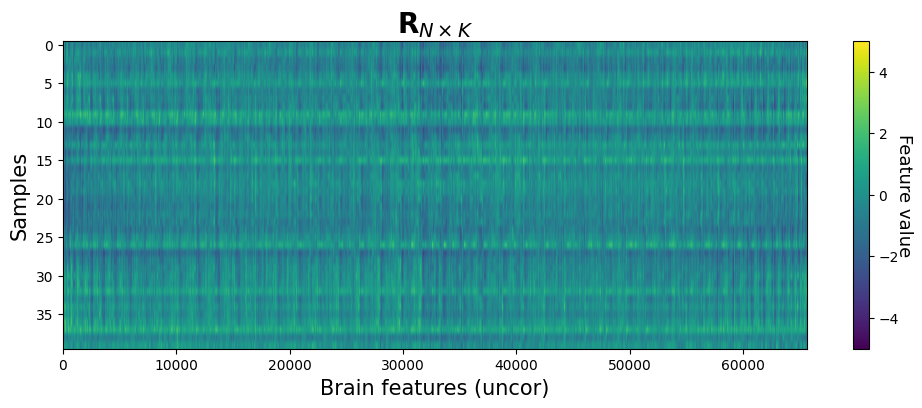

In [98]:
from scipy.linalg import sqrtm

# Design matrix
X = dm_face.to_numpy()
R_unc = sqrtm(X.T @ X) @ R_face

#There seems to be some outliers in the data that we need to filter out.
R_unc[R_unc>5]=5
R_unc[R_unc<-5]=-5

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 4))
plt.imshow(R_unc, aspect='auto')
plt.xlabel('Brain features (uncor)', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.title(r'$\mathbf{R}_{N\times K}$', fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=10)
plt.show()

### Let's try to classify on the basis of these data
First, let's get some classification labels

In [99]:
#the events_df variable contains our log-file from the experiment (see above)
#The expression variable has the condition labels
events_df['expression']
condition=events_df['expression']
#Let's check that the shape fits with our data
print(condition.shape)
print(condition)

(40,)
0     smiling
1     smiling
2     neutral
3     smiling
4     neutral
5     neutral
6     smiling
7     neutral
8     smiling
9     neutral
12    smiling
15    neutral
16    neutral
17    neutral
18    smiling
19    smiling
20    neutral
21    smiling
22    smiling
23    neutral
24    neutral
25    smiling
26    smiling
27    neutral
28    neutral
29    smiling
30    smiling
33    neutral
34    smiling
35    neutral
36    neutral
37    neutral
38    smiling
41    smiling
42    neutral
43    smiling
44    smiling
45    neutral
48    smiling
49    neutral
Name: expression, dtype: object


We have so many voxels in our data, that it is unfeasible to use them all. In this example, we will therefore select every 100th voxel. 
NB: This is a completely arbitrary/pragmatic choice.

(40, 557)


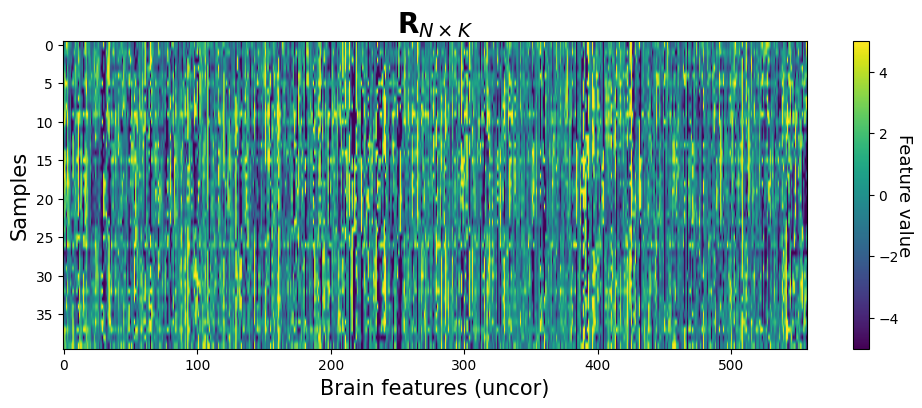

In [100]:
#We will use numpy's slicing [start:stop:step]
X=R_unc[:,10000::100]
print(X.shape)
plt.figure(figsize=(12, 4))
plt.imshow(X, aspect='auto')
plt.xlabel('Brain features (uncor)', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.title(r'$\mathbf{R}_{N\times K}$', fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=10)
plt.show()

Now, let's try a classifier. We will use NaiveBayes again.

In [103]:
X=R_unc[:,10000::100]
y=condition  

# We will use these classifiers, just to illustrate the varieties
classifier = GaussianNB()
#clf=[name,classifier]

X = StandardScaler().fit_transform(X)
#Divide the training set and test set into equal sizes.
X_train, X_test, y_train, y_test = \
   train_test_split(X, y, test_size=.5, random_state=42)
#Fit the training data
classifier.fit(X_train, y_train)
#Predict the test data, get score
score = classifier.score(X_test, y_test)
print(score)

0.3


Didn't go so well, did it? 
Real data is a nuisance. You may want to try other data selections or classifiers.
Later, we will look at some more informed ways we can select the voxels.

Alright, that was it for this lab! We have covered the basics of experimental design and pattern estimation techniques for fMRI data. Note that there are many other (more advanced) things related to pattern estimation that we haven't discussed...